# Определение возраста покупателей

## Исследовательский анализ данных

Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

SEED = 12345

Импорт функций.

In [2]:
line = '-'*80

#Информация о таблице
def percentage_passes (dataset):
    print(dataset.info())
    print(line)
    print('Количество пропущенных значений таблицы:')
    for col in dataset.columns:
        datcol = np.mean(dataset[col].isnull())
        print(col, datcol)  
        
    print(line)
    print('Количество дубликатов -', dataset.duplicated().sum())
    print('Минимальное значение -', dataset.min())
    
def data_analysis (variable, column):
    means = variable[column].mean()
    medians = variable[column].median()
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].axvline(x=means, color='green')
    axes[0].axvline(x=medians, color='red')
    axes[0].legend(['Среднее значение - {:.2f}'.format(means),
                    'Медианное значение - {:.2f}'.format(medians)])
    axes[0].set_title(f'Гистограмма для - {column}', fontsize=15)
    axes[0].set_ylabel('Количество', fontsize=10)
    
    sns.histplot(variable, bins=20, kde=True, ax=axes[0], x=column)
    axes[1].set_title(f'График ящик с усами для - {column}', fontsize=15)
    sns.boxplot(data=variable, ax=axes[1], y=column)
    axes[1].set_ylabel(column, fontsize=10)
    plt.show()

Загрузка таблицы а так-же изучение информации.

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
percentage_passes(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
--------------------------------------------------------------------------------
Количество пропущенных значений таблицы:
file_name 0.0
real_age 0.0
--------------------------------------------------------------------------------
Количество дубликатов - 0
Минимальное значение - file_name    000000.jpg
real_age              1
dtype: object


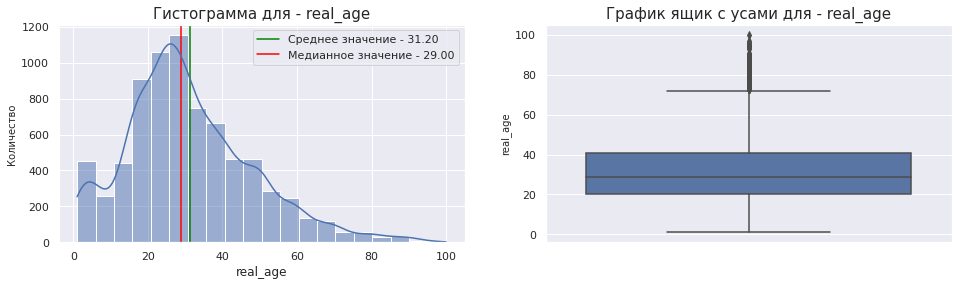

In [6]:
data_analysis(data, 'real_age')

Выведу 15 фото.

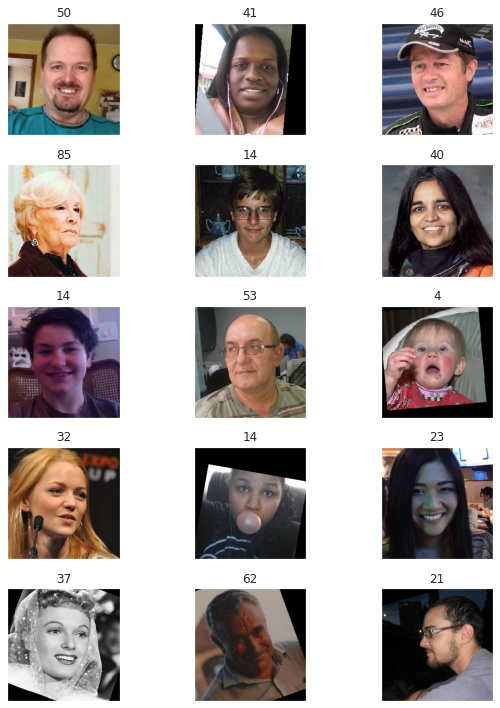

In [7]:
features, target = next(datagen_flow)

vert = 5 
gor = 3

fig = plt.figure(figsize=(10,10))

for i in range(vert * gor):
    fig.add_subplot(vert, gor, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<b>Вывод</b>
<br>Таблица имеет 2 столбца и 7591 строк. Пропусков и дубликатов нет.
<br>Средний возраст в таблице - 30 лет.
<br>Больше всего встречаеться возраст от 20 до 30 лет.  Распределение возраста от 1 до 100 лет. 
<br>Изображения в датасете взяты из разных источников. По первым 15 фото можно увидеть, что датасет сформирован из скриншотов кино, вырезок журналов, интервью или презентаций, а также просто найдены в интернете. Изображения также имеют разное качество. Это может позволить модели лучше предсказывать некачественные изображения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
def load_train(path):

    datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 30,
        height_shift_range = 30,
        zoom_range = [.8, .8],
        horizontal_flip = True, 
        rescale=1./255,
        validation_split=.25
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        #labels='inferred', 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        #batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return datagen_flow


def load_test(path):

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.25)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv') ,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age', 
        target_size=(224, 224),
        #sbatch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        #weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=.00001)
    model.compile(optimizer=optimizer_adam, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

    model.summary() 

    return model


def train_model(model,train_datagen_flow, 
                test_datagen_flow, 
                batch_size=None, epochs=15, 
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Вывод функции.

Epoch 1/15
2025-06-11 15:55:04.249825: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-11 15:55:04.725581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 108s - loss: 881.5404 - mean_absolute_error: 24.7863 - val_loss: 659.8562 - val_mean_absolute_error: 20.7326
Epoch 2/15
178/178 - 94s - loss: 281.4017 - mean_absolute_error: 12.9634 - val_loss: 587.4554 - val_mean_absolute_error: 19.2012
Epoch 3/15
178/178 - 96s - loss: 152.9198 - mean_absolute_error: 9.2134 - val_loss: 634.6014 - val_mean_absolute_error: 20.1284
Epoch 4/15
178/178 - 97s - loss: 115.4616 - mean_absolute_error: 8.0698 - val_loss: 176.8795 - val_mean_absolute_error: 9.9959
Epoch 5/15
178/178 - 94s - loss: 99.5860 - mean_absolute_error: 7.4850 - val_loss: 105.5182 - val_mean_absolute_error: 7.7665
Epoch 6/15
178/178 - 95s - loss: 91.5412 - mean_absolute_error: 7.2489 - val_loss: 101.8853 - val_mean_absolute_error: 7.4312
Epoch 7/15
178/178 - 95s - loss: 80.6623 - mean_absolute_error: 6.8165 - val_loss: 90.3251 - val_mean_absolute_error: 7.0754
Epoch 8/15
178/178 - 94s - loss: 75.4575 - mean_absolute_error: 6.6047 - val_loss: 99.5851 - val_mean_absolute_error: 7.6181
Epoch 9/15
178/178 - 94s - loss: 69.6898 - mean_absolute_error: 6.3649 - val_loss: 90.6319 - val_mean_absolute_error: 7.2987
Epoch 10/15
178/178 - 93s - loss: 65.9621 - mean_absolute_error: 6.2101 - val_loss: 99.2461 - val_mean_absolute_error: 7.3507
Epoch 11/15
178/178 - 94s - loss: 60.6397 - mean_absolute_error: 6.0012 - val_loss: 94.6749 - val_mean_absolute_error: 7.1804
Epoch 12/15
178/178 - 97s - loss: 59.0955 - mean_absolute_error: 5.8792 - val_loss: 90.3572 - val_mean_absolute_error: 7.0459
Epoch 13/15
178/178 - 90s - loss: 53.1411 - mean_absolute_error: 5.6048 - val_loss: 98.1559 - val_mean_absolute_error: 7.2413
Epoch 14/15
178/178 - 90s - loss: 50.7658 - mean_absolute_error: 5.4696 - val_loss: 90.0692 - val_mean_absolute_error: 6.9969
Epoch 15/15
178/178 - 90s - loss: 48.8296 - mean_absolute_error: 5.3690 - val_loss: 93.5012 - val_mean_absolute_error: 7.0924
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 93.5012 - mean_absolute_error: 7.0924
Test MAE: 7.0924

## Анализ обученной модели

<b>Вывод</b>
<br>Была обучена и протестирована нейронная сеть ResNet50.
<br>Полученное значение MAE — 7,09, а это значит, что модель ошибается в среднем на 7 лет. Такой результат не подходит для определения возраста покупателя при продаже, например, алкоголя, но может помочь при рекомендации товара для возрастных групп.
<br>Для улучшения модели можно использовать набор данных с изображениями лиц людей, не достигших 20 лет.